# Apply time series modelling using SARIMA

This notebook try to analyze the time-series data using Auto-regressive integrated moving average (ARIMA)

In [4]:
# import necessary packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

import sys
sys.path.append("../../PredictPIServer/ValePredictPI/")

from vale_connect import ValeConnect

In [17]:
# import PI Data on the same timeframe
# create connection
server_root = '142.40.33.208'
server_base = 'pti-pi'

conn = ValeConnect(server_root, server_base)

pi_tag = ['U-LGS1-UGB-X-PK-PK-70-AI','U-LGS1-UGB-Y-PK-PK-340-AI']
time_list = ['2023-10-11 16:07:48','2023-10-11 16:08:58']

for i in range(len(pi_tag)):
    x_tag_wid = conn.get_webid_point(x_tag[i])

    # for limited data
    # value_resp = conn.get_stream_rec_valuetimestamp_pd(x_tag_wid, time_list)

    # for streaming data
    value_resp = conn.get_stream_rec_valuetime_pd(x_tag_wid)

    if i==0:
        data_pi = value_resp
    else:
        data_pi.insert(i+1, "Values " + str(i), value_resp['Values'])

data_pi

,Timestamps,Values,Values 1
0,2024-05-07T03:34:40.0491943Z,186.300000,201.900009
1,2024-05-07T03:34:50.0627593Z,193.700000,207.800000
2,2024-05-07T03:35:00.061325Z,189.800000,198.700000
3,2024-05-07T03:35:10.0479125Z,189.600000,200.100000
4,2024-05-07T03:35:20.050476Z,193.900009,194.900009
...,...,...,...
995,2024-05-07T06:23:20.0190887Z,196.200000,205.100000
996,2024-05-07T06:23:30.0246734Z,196.100000,192.700000
997,2024-05-07T06:23:40.0172424Z,191.900009,208.100000
998,2024-05-07T06:23:50.0238189Z,201.100000,206.700000


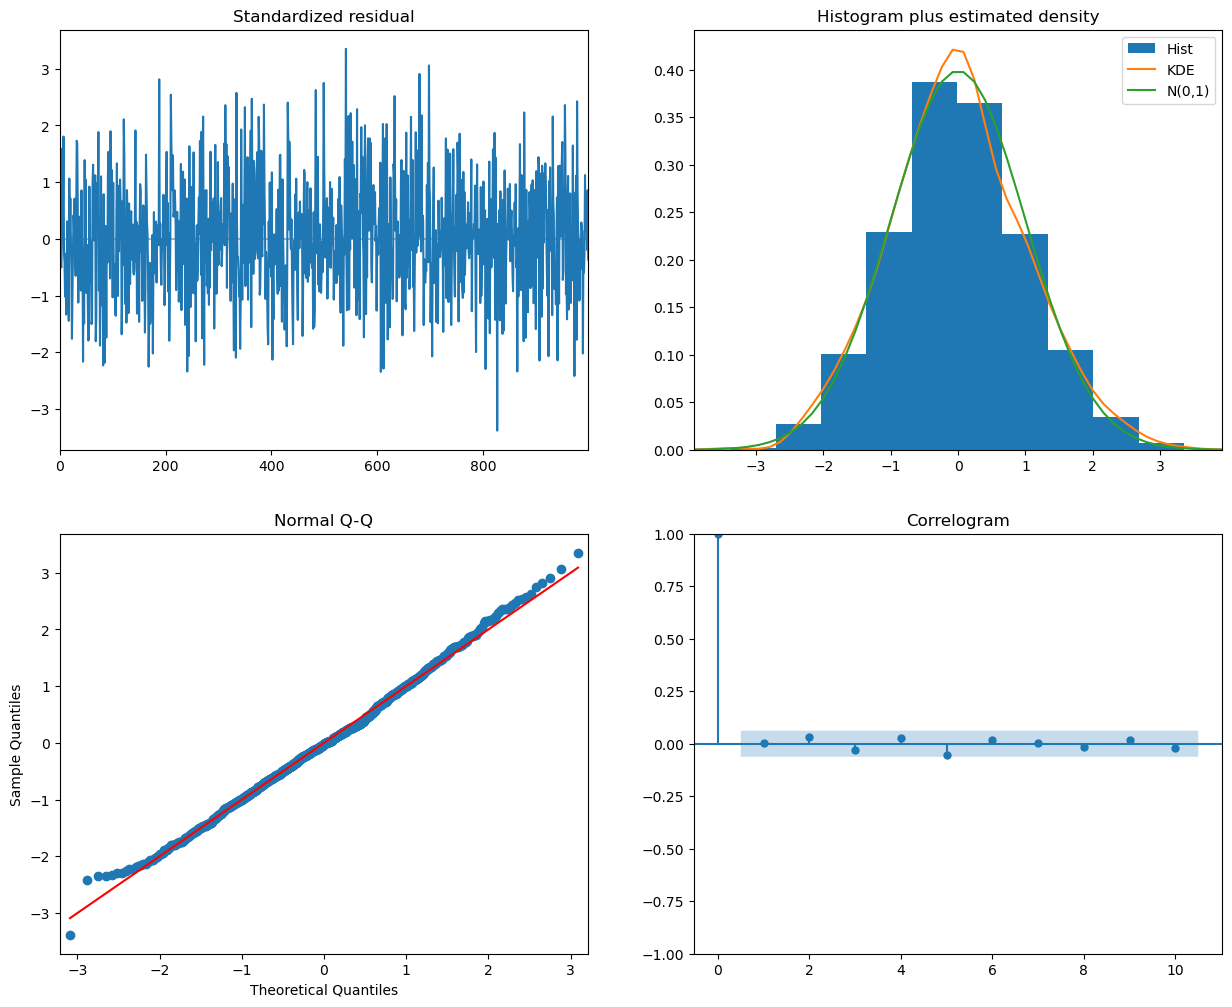

In [21]:
#Standard ARIMA Model
df = data_pi
ARIMA_model = pm.auto_arima(data_pi['Values'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [22]:
def forecast(ARIMA_model, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["#Passengers"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Airline Passengers")
    plt.show()

forecast(ARIMA_model)

TypeError: unsupported operand type(s) for +: 'int' and 'DateOffset'